# Reproducibility: Cutout

### Original Paper: Improved Regularization of Convolutional Neural Networks with Cutout
### Original Code: https://github.com/uoguelph-mlrg/Cutout

# 1. Introduction

This Jupyter notebook is designed to illustrate the implementation and usage of the CutOut data augmentation technique in deep learning, specifically in the context of Convolutional Neural Networks (CNNs).

### CutOut: An Overview
CutOut is a regularization and data augmentation technique for convolutional neural networks (CNNs). It involves randomly masking out square regions of input during training. This helps to improve the robustness and overall performance of CNNs by encouraging the network to better utilize the full context of the image, rather than relying on the presence of a small set of specific visual features.

CutOut is computationally efficient as it can be applied during data loading in parallel with the main training task. It can be used in conjunction with existing forms of data augmentation and other regularizers to further improve model performance.

The technique has been evaluated with state-of-the-art architectures on popular image recognition datasets such as CIFAR-10, CIFAR-100, and SVHN, often achieving state-of-the-art or near state-of-the-art results.


# 2. Setting Up the Environment

## Import Library

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import datasets, transforms


import math
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot as plt
import pdb
import argparse
from tqdm import tqdm
import os

In [2]:
print(torch. __version__)

2.0.1+cu118


In [26]:
if not os.path.exists('/content/checkpoints'):
    os.makedirs('/content/checkpoints')

# 3. Data Preprocessing

## Cutout Code

In [4]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

## Image without Cutout

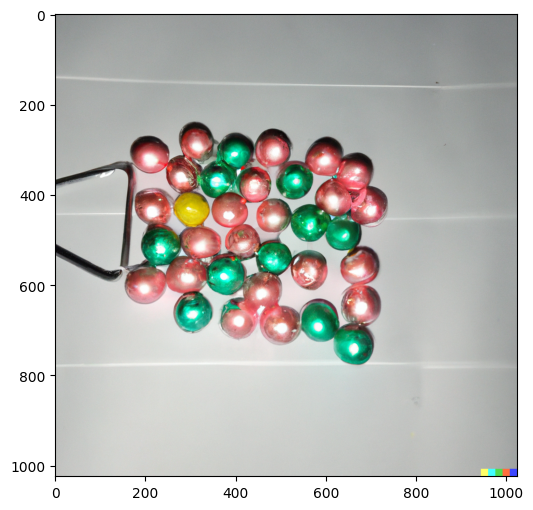

In [5]:
# Load an image
img = Image.open('/content/sample.png')

# Convert the image to a PyTorch tensor
img_tensor = transforms.ToTensor()(img)

# Display the original image
plt.figure(figsize=(6,6))
plt.imshow(img_tensor.permute(1, 2, 0))
plt.show()

## Image with Cutout

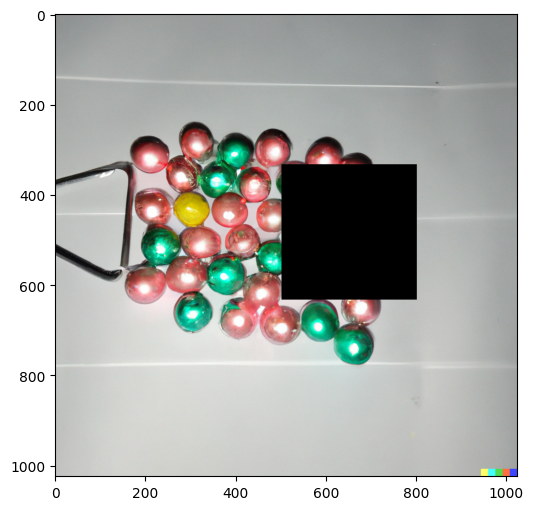

In [6]:
# Create a Cutout object
cutout = Cutout(n_holes=1, length=300)

# Apply Cutout to the image
img_tensor_cutout = cutout(img_tensor)

# Convert the tensor back to an image for visualization
img_cutout = transforms.ToPILImage()(img_tensor_cutout)

# Display the image with cutout applied
plt.figure(figsize=(6,6))
plt.imshow(img_tensor_cutout.permute(1, 2, 0))
plt.show()

## Implement Cutout on CIFAR10 Dataset

In [7]:
# Define your transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #,
    #Cutout(n_holes=1, length=16)  # Cutout applied here
])

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [8]:
# Load the CIFAR-10 dataset with transformations applied
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:23<00:00, 7208728.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


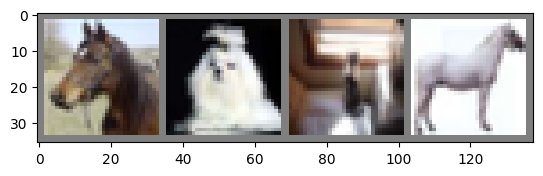

In [9]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images before Cutout
imshow(torchvision.utils.make_grid(images))

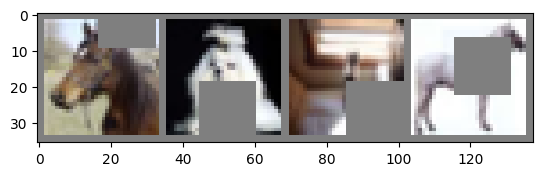

In [10]:
# Apply Cutout and show images after
cutout_images = torch.stack([Cutout(n_holes=1, length=16)(img) for img in images])
imshow(torchvision.utils.make_grid(cutout_images))

# 4. Methods and Implementation

## ResNet Code

In [18]:
# ResNet

'''ResNet18/34/50/101/152 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(in_planes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),nn.BatchNorm2d(self.expansion*planes))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = conv3x3(3,64)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
      return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18(num_classes=10):
  return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
  return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
  return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
  return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
  return ResNet(Bottleneck, [3,8,36,3], num_classes)

def test_resnet():
  net = ResNet50()
  y = net(Variable(torch.randn(1,3,32,32)))
  print(y.size())

# test_resnet()

## WideResNet Code

In [12]:
# WideResNet

# From https://github.com/xternalz/WideResNet-pytorch

import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))

        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        out = self.fc(out)
        return out

In [20]:
class CSVLogger():
    def __init__(self, args, fieldnames, filename='log.csv'):

        self.filename = filename
        self.csv_file = open(filename, 'w')

        # Write model configuration at top of csv
        writer = csv.writer(self.csv_file)
        for arg in vars(args):
            writer.writerow([arg, getattr(args, arg)])
        writer.writerow([''])

        self.writer = csv.DictWriter(self.csv_file, fieldnames=fieldnames)
        self.writer.writeheader()

        self.csv_file.flush()

    def writerow(self, row):
        self.writer.writerow(row)
        self.csv_file.flush()

    def close(self):
        self.csv_file.close()

# 5. Model Training and Evaluation

In [13]:
# run train.py --dataset cifar10 --model resnet18 --data_augmentation --cutout --length 16
# run train.py --dataset cifar100 --model resnet18 --data_augmentation --cutout --length 8
# run train.py --dataset svhn --model wideresnet --learning_rate 0.01 --epochs 160 --cutout --length 20

'''
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms
'''

#from util.misc import CSVLogger
#from util.cutout import Cutout

#from model.resnet import ResNet18
#from model.wide_resnet import WideResNet
'''
model_options = ['resnet18', 'wideresnet']
dataset_options = ['cifar10', 'cifar100', 'svhn']

parser = argparse.ArgumentParser(description='CNN')
parser.add_argument('--dataset', '-d', default='cifar10',
                    choices=dataset_options)
parser.add_argument('--model', '-a', default='resnet18',
                    choices=model_options)
parser.add_argument('--batch_size', type=int, default=128,
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='learning rate')
parser.add_argument('--data_augmentation', action='store_true', default=False,
                    help='augment data by flipping and cropping')
parser.add_argument('--cutout', action='store_true', default=False,
                    help='apply cutout')
parser.add_argument('--n_holes', type=int, default=1,
                    help='number of holes to cut out from image')
parser.add_argument('--length', type=int, default=16,
                    help='length of the holes')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=0,
                    help='random seed (default: 1)')

args = parser.parse_args()
'''

def main(args):
  args.cuda = not args.no_cuda and torch.cuda.is_available()
  cudnn.benchmark = True  # Should make training should go faster for large models


  torch.manual_seed(args.seed)
  if args.cuda:
      torch.cuda.manual_seed(args.seed)

  test_id = args.dataset + '_' + args.model

  print(args)

  # Image Preprocessing
  if args.dataset == 'svhn':
      normalize = transforms.Normalize(mean=[x / 255.0 for x in[109.9, 109.7, 113.8]],
                                      std=[x / 255.0 for x in [50.1, 50.6, 50.8]])
  else:
      normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                      std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

  train_transform = transforms.Compose([])
  if args.data_augmentation:
      train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
      train_transform.transforms.append(transforms.RandomHorizontalFlip())
  train_transform.transforms.append(transforms.ToTensor())
  train_transform.transforms.append(normalize)
  if args.cutout:
      train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length))


  test_transform = transforms.Compose([
      transforms.ToTensor(),
      normalize])

  if args.dataset == 'cifar10':
      num_classes = 10
      train_dataset = datasets.CIFAR10(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

      test_dataset = datasets.CIFAR10(root='data/',
                                      train=False,
                                      transform=test_transform,
                                      download=True)
  elif args.dataset == 'cifar100':
      num_classes = 100
      train_dataset = datasets.CIFAR100(root='data/',
                                        train=True,
                                        transform=train_transform,
                                        download=True)

      test_dataset = datasets.CIFAR100(root='data/',
                                      train=False,
                                      transform=test_transform,
                                      download=True)
  elif args.dataset == 'svhn':
      num_classes = 10
      train_dataset = datasets.SVHN(root='data/',
                                    split='train',
                                    transform=train_transform,
                                    download=True)

      extra_dataset = datasets.SVHN(root='data/',
                                    split='extra',
                                    transform=train_transform,
                                    download=True)

      # Combine both training splits (https://arxiv.org/pdf/1605.07146.pdf)
      data = np.concatenate([train_dataset.data, extra_dataset.data], axis=0)
      labels = np.concatenate([train_dataset.labels, extra_dataset.labels], axis=0)
      train_dataset.data = data
      train_dataset.labels = labels

      test_dataset = datasets.SVHN(root='data/',
                                  split='test',
                                  transform=test_transform,
                                  download=True)

  # Data Loader (Input Pipeline)
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=args.batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=2)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=args.batch_size,
                                            shuffle=False,
                                            pin_memory=True,
                                            num_workers=2)

  if args.model == 'resnet18':
      cnn = ResNet18(num_classes=num_classes)
  elif args.model == 'wideresnet':
      if args.dataset == 'svhn':
          cnn = WideResNet(depth=16, num_classes=num_classes, widen_factor=8,
                          dropRate=0.4)
      else:
          cnn = WideResNet(depth=28, num_classes=num_classes, widen_factor=10,
                          dropRate=0.3)

  cnn = cnn.cuda()
  criterion = nn.CrossEntropyLoss().cuda()
  cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate,
                                  momentum=0.9, nesterov=True, weight_decay=5e-4)

  if args.dataset == 'svhn':
      scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)
  else:
      scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)

  filename = 'logs/' + test_id + '.csv'
  csv_logger = CSVLogger(args=args, fieldnames=['epoch', 'train_acc', 'test_acc'], filename=filename)


  def test(loader):
      cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
      correct = 0.
      total = 0.
      for images, labels in loader:
          images = images.cuda()
          labels = labels.cuda()

          with torch.no_grad():
              pred = cnn(images)

          pred = torch.max(pred.data, 1)[1]
          total += labels.size(0)
          correct += (pred == labels).sum().item()

      val_acc = correct / total
      cnn.train()
      return val_acc


  for epoch in range(args.epochs):

      xentropy_loss_avg = 0.
      correct = 0.
      total = 0.

      progress_bar = tqdm(train_loader)
      for i, (images, labels) in enumerate(progress_bar):
          progress_bar.set_description('Epoch ' + str(epoch))

          images = images.cuda()
          labels = labels.cuda()

          cnn.zero_grad()
          pred = cnn(images)

          xentropy_loss = criterion(pred, labels)
          xentropy_loss.backward()
          cnn_optimizer.step()

          xentropy_loss_avg += xentropy_loss.item()

          # Calculate running average of accuracy
          pred = torch.max(pred.data, 1)[1]
          total += labels.size(0)
          correct += (pred == labels.data).sum().item()
          accuracy = correct / total

          progress_bar.set_postfix(
              xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
              acc='%.3f' % accuracy)

      test_acc = test(test_loader)
      tqdm.write('test_acc: %.3f' % (test_acc))

      scheduler.step(epoch)  # Use this line for PyTorch <1.4
      # scheduler.step()     # Use this line for PyTorch >=1.4

      row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
      csv_logger.writerow(row)

  torch.save(cnn.state_dict(), 'checkpoints/' + test_id + '.pt')
  csv_logger.close()

In [14]:
class Args:
    dataset = 'cifar10'
    model = 'resnet18'
    batch_size = 128
    epochs = 200
    learning_rate = 0.1
    data_augmentation = False
    cutout = False
    n_holes = 1
    length = 16
    no_cuda = False
    seed = 0

args = Args()

In [ ]:
main(args)

Files already downloaded and verified
Files already downloaded and verified


Epoch 0: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, acc=0.484, xentropy=1.426]


test_acc: 0.546


Epoch 1: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, acc=0.686, xentropy=0.889]


test_acc: 0.659


Epoch 2: 100%|██████████| 391/391 [00:25<00:00, 15.18it/s, acc=0.758, xentropy=0.688]


test_acc: 0.721


Epoch 3: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s, acc=0.808, xentropy=0.550]


test_acc: 0.710


Epoch 4: 100%|██████████| 391/391 [00:25<00:00, 15.08it/s, acc=0.842, xentropy=0.455]


test_acc: 0.766


Epoch 5: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s, acc=0.864, xentropy=0.391]


test_acc: 0.778


Epoch 6: 100%|██████████| 391/391 [00:25<00:00, 15.07it/s, acc=0.884, xentropy=0.332]


test_acc: 0.790


Epoch 7: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s, acc=0.897, xentropy=0.299]


test_acc: 0.740


Epoch 8: 100%|██████████| 391/391 [00:25<00:00, 15.08it/s, acc=0.907, xentropy=0.268]


test_acc: 0.764


Epoch 9: 100%|██████████| 391/391 [00:25<00:00, 15.13it/s, acc=0.914, xentropy=0.246]


test_acc: 0.786


Epoch 10: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s, acc=0.922, xentropy=0.227]


test_acc: 0.769


Epoch 11: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, acc=0.925, xentropy=0.217]


test_acc: 0.694


Epoch 12: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s, acc=0.930, xentropy=0.204]


test_acc: 0.790


Epoch 13: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s, acc=0.932, xentropy=0.199]


test_acc: 0.794


Epoch 14: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, acc=0.931, xentropy=0.197]


test_acc: 0.782


Epoch 15: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, acc=0.935, xentropy=0.188]


test_acc: 0.774


Epoch 16: 100%|██████████| 391/391 [00:26<00:00, 15.04it/s, acc=0.936, xentropy=0.186]


test_acc: 0.786


Epoch 17: 100%|██████████| 391/391 [00:26<00:00, 15.02it/s, acc=0.937, xentropy=0.182]


test_acc: 0.798


Epoch 18: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s, acc=0.938, xentropy=0.182]


test_acc: 0.766


Epoch 19: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, acc=0.938, xentropy=0.181]


test_acc: 0.775


Epoch 20: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, acc=0.940, xentropy=0.178]


test_acc: 0.761


Epoch 21: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, acc=0.936, xentropy=0.180]


test_acc: 0.769


Epoch 22: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s, acc=0.943, xentropy=0.169]


test_acc: 0.806


Epoch 23: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s, acc=0.940, xentropy=0.174]


test_acc: 0.798


Epoch 24: 100%|██████████| 391/391 [00:26<00:00, 15.04it/s, acc=0.942, xentropy=0.172]


test_acc: 0.762


Epoch 25: 100%|██████████| 391/391 [00:26<00:00, 14.92it/s, acc=0.938, xentropy=0.175]


test_acc: 0.755


Epoch 26: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, acc=0.940, xentropy=0.175]


test_acc: 0.781


Epoch 27: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s, acc=0.944, xentropy=0.164]


test_acc: 0.790


Epoch 28: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, acc=0.942, xentropy=0.168]


test_acc: 0.815


Epoch 29: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s, acc=0.943, xentropy=0.170]


test_acc: 0.787


Epoch 30: 100%|██████████| 391/391 [00:26<00:00, 14.90it/s, acc=0.940, xentropy=0.175]


test_acc: 0.793


Epoch 31: 100%|██████████| 391/391 [00:25<00:00, 15.09it/s, acc=0.943, xentropy=0.168]


test_acc: 0.775


Epoch 32: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s, acc=0.943, xentropy=0.171]


test_acc: 0.775


Epoch 33: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s, acc=0.940, xentropy=0.173]


test_acc: 0.797


Epoch 34: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s, acc=0.944, xentropy=0.162]


test_acc: 0.746


Epoch 35: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s, acc=0.940, xentropy=0.171]


test_acc: 0.760


Epoch 36: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s, acc=0.942, xentropy=0.169]


test_acc: 0.808


Epoch 37: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s, acc=0.944, xentropy=0.164]


test_acc: 0.812


Epoch 38: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s, acc=0.945, xentropy=0.161]


test_acc: 0.793


Epoch 39: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, acc=0.942, xentropy=0.166]


test_acc: 0.777


Epoch 40: 100%|██████████| 391/391 [00:25<00:00, 15.07it/s, acc=0.943, xentropy=0.167]


test_acc: 0.768


Epoch 41: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, acc=0.945, xentropy=0.158]


test_acc: 0.761


Epoch 42: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s, acc=0.942, xentropy=0.171]


test_acc: 0.753


Epoch 43: 100%|██████████| 391/391 [00:26<00:00, 14.96it/s, acc=0.946, xentropy=0.159]


test_acc: 0.809


Epoch 44: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s, acc=0.941, xentropy=0.170]


test_acc: 0.785


Epoch 45: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s, acc=0.945, xentropy=0.160]


test_acc: 0.788


Epoch 46: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s, acc=0.944, xentropy=0.162]


test_acc: 0.788


Epoch 47: 100%|██████████| 391/391 [00:25<00:00, 15.06it/s, acc=0.942, xentropy=0.170]


test_acc: 0.778


Epoch 48: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s, acc=0.944, xentropy=0.163]


test_acc: 0.772


Epoch 49: 100%|██████████| 391/391 [00:25<00:00, 15.21it/s, acc=0.946, xentropy=0.158]


test_acc: 0.778


Epoch 50: 100%|██████████| 391/391 [00:25<00:00, 15.13it/s, acc=0.945, xentropy=0.163]


test_acc: 0.777


Epoch 51: 100%|██████████| 391/391 [00:25<00:00, 15.13it/s, acc=0.944, xentropy=0.165]


test_acc: 0.802


Epoch 52: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s, acc=0.943, xentropy=0.163]


test_acc: 0.790


Epoch 53: 100%|██████████| 391/391 [00:25<00:00, 15.08it/s, acc=0.943, xentropy=0.163]


test_acc: 0.790


Epoch 54: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s, acc=0.944, xentropy=0.160]


test_acc: 0.796


Epoch 55: 100%|██████████| 391/391 [00:25<00:00, 15.20it/s, acc=0.944, xentropy=0.163]


test_acc: 0.797


Epoch 56: 100%|██████████| 391/391 [00:25<00:00, 15.10it/s, acc=0.945, xentropy=0.160]


test_acc: 0.812


Epoch 57: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s, acc=0.944, xentropy=0.164]


test_acc: 0.801


Epoch 58: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, acc=0.944, xentropy=0.162]


test_acc: 0.796


Epoch 59: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s, acc=0.944, xentropy=0.166]


test_acc: 0.791


Epoch 60: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s, acc=0.947, xentropy=0.157]


test_acc: 0.792


Epoch 61: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, acc=0.989, xentropy=0.043]


test_acc: 0.871


Epoch 62: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s, acc=1.000, xentropy=0.008]


test_acc: 0.874


Epoch 63: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s, acc=1.000, xentropy=0.005]


test_acc: 0.875


Epoch 64: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s, acc=1.000, xentropy=0.004]


test_acc: 0.876


Epoch 65: 100%|██████████| 391/391 [00:25<00:00, 15.17it/s, acc=1.000, xentropy=0.004]


test_acc: 0.878


Epoch 66: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s, acc=1.000, xentropy=0.004]


test_acc: 0.878


Epoch 67: 100%|██████████| 391/391 [00:26<00:00, 15.02it/s, acc=1.000, xentropy=0.004]


test_acc: 0.878


Epoch 68: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s, acc=1.000, xentropy=0.003]


test_acc: 0.878


Epoch 69: 100%|██████████| 391/391 [00:26<00:00, 14.67it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 70: 100%|██████████| 391/391 [00:25<00:00, 15.17it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 71: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 72: 100%|██████████| 391/391 [00:25<00:00, 15.09it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 73: 100%|██████████| 391/391 [00:25<00:00, 15.21it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 74: 100%|██████████| 391/391 [00:25<00:00, 15.10it/s, acc=1.000, xentropy=0.003]


test_acc: 0.882


Epoch 75: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s, acc=1.000, xentropy=0.003]


test_acc: 0.881


Epoch 76: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s, acc=1.000, xentropy=0.003]


test_acc: 0.882


Epoch 77: 100%|██████████| 391/391 [00:25<00:00, 15.04it/s, acc=1.000, xentropy=0.003]


test_acc: 0.881


Epoch 78: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 79: 100%|██████████| 391/391 [00:26<00:00, 14.88it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 80: 100%|██████████| 391/391 [00:26<00:00, 14.67it/s, acc=1.000, xentropy=0.003]


test_acc: 0.880


Epoch 81: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s, acc=1.000, xentropy=0.003]


test_acc: 0.881


Epoch 82:  39%|███▊      | 151/391 [00:10<00:18, 12.85it/s, acc=1.000, xentropy=0.003]

# 6. Results and Analysis

# 7. Interactive Elements

# 8. Conclusion